# 네이버 영화리뷰 감성분석 도전하기 
#### 코드 읽어보면서 따라가기 (https://github.com/rurube/Aiffel_Online5/blob/master/Exploration4/naver_movie.ipynb)

#### 라이브러리 버전 확인

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

import pandas as pd

1.3.3
0.5.2
4.1.2


#### 1) 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### 2) 데이터로더 구성
* nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있음
* 이것을 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작
* data_loader 안에서 수행할 작업:
######
###### 데이터의 중복 제거
###### NaN 결측치 제거
###### 한국어 토크나이저로 토큰화
###### 불용어(Stopwords) 제거
###### 사전word_to_index 구성
###### 텍스트 스트링을 사전 인덱스 스트링으로 변환
###### X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 학습 데이터 중복 제거
    train_data = train_data.dropna(how = 'any')  # 학습 데이터 NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 테스트 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')  # 학습 데이터 NaN 결측치 제거
    
    X_train = [] #X_train 리스트 
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) #문장 단위 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        X_train.append(temp_x)

    X_test = [] #X_test 리스트
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) #문장 단위 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        X_test.append(temp_x)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>','<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

max len:  116
mean len:  15.98170773419436


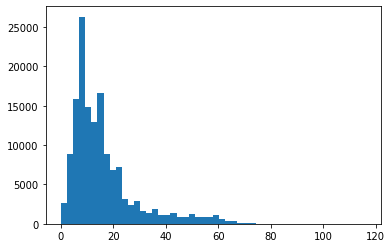

In [6]:
import matplotlib.pyplot as plt

print('max len: ', max(len(review) for review in X_train)) # 데이터셋 내 최대 문장 길이
print('mean len: ', sum(map(len, X_train))/len(X_train)) # 데이터셋 문장 길이 평균
plt.hist([len(review) for review in X_train], bins=50)
plt.show() # 문장 길이 분포 확인

In [7]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count += 1
    print(f'최대 길이: {max_len}, 커버 가능한 샘플 비율: {(count/len(nested_list))*100}')

In [8]:
below_threshold_len(50, X_train) # 최대 길이 50일 때 96퍼센트의 샘플 커버 가능

최대 길이: 50, 커버 가능한 샘플 비율: 96.03439547960761


In [9]:
import tensorflow as tf
# 최대 문장 길이 50으로 결정
# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre',maxlen=50)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre',maxlen=50)

#### 4) 모델 구성 및 validation set 구성 (3가지 이상)
* (1) LSTM

In [10]:
# LSTM 모델 준비
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000 
word_vector_dim = 50
hidden_units = 30

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, word_vector_dim))
model_lstm.add(LSTM(hidden_units))
model_lstm.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # val_loss가 4번 떨어지면 학습 멈춤
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 30)                9720      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 509,751
Trainable params: 509,751
Non-trainable params: 0
_________________________________________________________________


* (2) 1D CNN

In [12]:
# 1D CNN 모델 준비
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000
word_vector_dim_cnn = 16

model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, word_vector_dim_cnn))
model_cnn.add(Conv1D(16, 7, activation='relu'))
model_cnn.add(MaxPooling1D(5))
model_cnn.add(Conv1D(16, 7, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, shuffle=True,\
                                                 stratify=y_train, random_state=1234)

#### 5) 모델 훈련 개시
* (1) LSTM

In [14]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512,\
                    validation_data=(X_val, y_val), verbose=1) # LSTM 훈련

Epoch 1/15
172/172 [==============================] - 33s 10ms/step - loss: 0.4866 - accuracy: 0.7762 - val_loss: 0.3787 - val_accuracy: 0.8350
Epoch 2/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3345 - accuracy: 0.8582 - val_loss: 0.3508 - val_accuracy: 0.8478
Epoch 3/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3011 - accuracy: 0.8732 - val_loss: 0.3514 - val_accuracy: 0.8461
Epoch 4/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2796 - accuracy: 0.8840 - val_loss: 0.3514 - val_accuracy: 0.8488
Epoch 5/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2600 - accuracy: 0.8936 - val_loss: 0.3625 - val_accuracy: 0.8486
Epoch 6/15
172/172 [==============================] - 1s 7ms/step - loss: 0.2434 - accuracy: 0.9010 - val_loss: 0.3696 - val_accuracy: 0.8471
Epoch 00006: early stopping


In [15]:
result_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
print(result_lstm) # LSTM 결과

1537/1537 - 3s - loss: 0.3709 - accuracy: 0.8467
[0.37085679173469543, 0.8466953039169312]


* (2) 1D CNN

In [18]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512, \
                        validation_data=(X_val, y_val), verbose=1) # 1D CNN 훈련

Epoch 1/15
172/172 [==============================] - 21s 10ms/step - loss: 0.6134 - accuracy: 0.6452 - val_loss: 0.4994 - val_accuracy: 0.7484
Epoch 2/15
172/172 [==============================] - 1s 6ms/step - loss: 0.4564 - accuracy: 0.7745 - val_loss: 0.4702 - val_accuracy: 0.7656
Epoch 3/15
172/172 [==============================] - 1s 6ms/step - loss: 0.4199 - accuracy: 0.7944 - val_loss: 0.4697 - val_accuracy: 0.7656
Epoch 4/15
172/172 [==============================] - 1s 6ms/step - loss: 0.3974 - accuracy: 0.8068 - val_loss: 0.4768 - val_accuracy: 0.7644
Epoch 5/15
172/172 [==============================] - 1s 6ms/step - loss: 0.3763 - accuracy: 0.8186 - val_loss: 0.4874 - val_accuracy: 0.7647
Epoch 6/15
172/172 [==============================] - 1s 6ms/step - loss: 0.3526 - accuracy: 0.8304 - val_loss: 0.5025 - val_accuracy: 0.7624
Epoch 7/15
172/172 [==============================] - 1s 6ms/step - loss: 0.3272 - accuracy: 0.8439 - val_loss: 0.5264 - val_accuracy: 0.7599
Epoc

In [19]:
result_cnn = model_cnn.evaluate(X_test, y_test, verbose=2)
print(result_cnn) #1D CNN 결과

1537/1537 - 3s - loss: 0.5223 - accuracy: 0.7571
[0.5222887992858887, 0.7570844292640686]
